## EE5175 -Image Signal Processing
### Lab-2

## Occlusion detection

###### import libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.io import imread 
import os
import math as m

###### read image

In [2]:
img_1 = imread('./IMG1.png')
img_2 = imread('./IMG2.png')

###### plot images

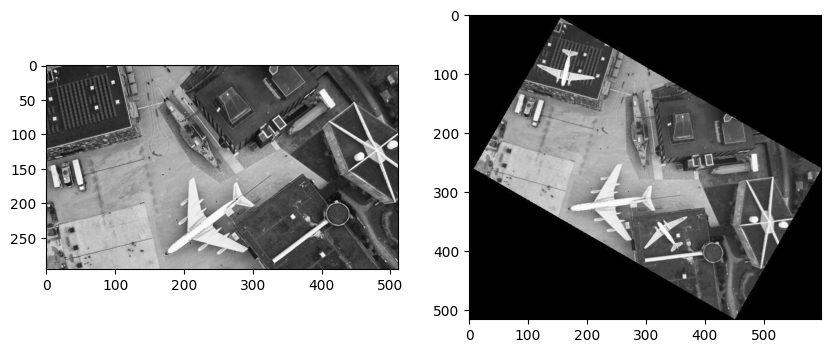

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_1 , 'gray')
plt.subplot(1,2,2)
plt.imshow(img_2 , 'gray')
plt.show()

##### points given 

In [4]:
points_1 = np.array([[29, 124], [157, 372]])
points_2 = np.array([[93, 248], [328, 399]])

##### matrix formation

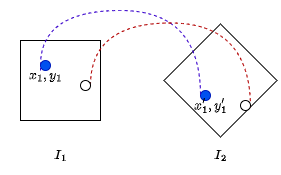


$$
x_{i}^{'} = \frac{ax_{i}+by_{i}+c}{h}
$$


$$
y_{i}^{'} = \frac{-bx_{i}+ay_{i}+d}{h}
$$


$$
A_{i}\bar{h} = 0
$$

$$
A_{i} = \begin{bmatrix} x_{i} & y_{i} & 1 & 0 & -x_{i}^{'} \\ y_{i} & -x_{i} & 0 & 1 & -y_{i}^{'} \end{bmatrix}
$$

NOTE: All the notations used here are as used in the class

In [5]:
def matrix_form(points_1, points_2):
    num_of_corr = len(points_1)
    
    mat_ = np.zeros((2*num_of_corr, 5))
    for i in range(num_of_corr):
        x, y = points_1[i]
        x_dash, y_dash = points_2[i]
        mat_[2*i] = [x, y, 1, 0, -x_dash]
        mat_[2*i+1] = [y, -x, 0, 1, -y_dash]
#         print(mat_)
    return mat_

##### homography matrix from SVD 

###### https://en.wikipedia.org/wiki/Singular_value_decomposition
###### https://math.stackexchange.com/questions/3509039/calculate-homography-with-and-without-svd

In [6]:
def homography_matrix(matrix_):
    u, s, v_transpose = np.linalg.svd(matrix_)  #svd of the form decreasing order 
    a, b, c, d, h = v_transpose[-1]   # required elements to form the matrix in the reverse order
    H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)  # reshaping it to a matrix of order 3*3
    return H

##### Bilinear Interpolation

In [7]:
def bilinear_interpolation(source , x , y ): 
    '''
    input params : source =  source image 
                    x =  x coordinate 
                    y = y coordinate 
                    
        output : returns a target image
    '''
    
    xx = source.shape[0]   # shape of the input image 
    yy = source.shape[1]    
    
    x_dash = m.floor(x)    #  floor value of the coordinate (x ' and y' as mentioned in the class)  
    y_dash = m.floor(y)
    
    a = x - x_dash       # finding a and b i.e difference between actual and the floor value of the coordinate
    b = y - y_dash
    
    if x_dash >= 0 and y_dash>=0 and x_dash <= xx-2 and y_dash <= yy-2:  ##formula 
        target_img =(1-a)*(1-b)*source[x_dash,y_dash]+ (1-a)*b*source[x_dash,y_dash+1]+ a*(1-b)*source[x_dash+1,y_dash]+a*b*source[x_dash+1,y_dash+1]
        
    else:
        target_img = 0     # without using this condition , zeros wouldn't be created , it wud repeat the same values
        
    return target_img

##### Image after Homography 

In [8]:
def get_image(source_image, H):
    x, y = np.shape(source_image)
    H_inverse = np.linalg.inv(H)
    target_image = np.zeros((x, y))

    for xt in range(x):
        for yt in range(y):
            vec = np.array([xt, yt, 1]) #making all the coordinates to homography (3*1) 
            # req = inverse_h * given (H_inv = (3*3) homogeneous coord of vec(3*1))
            temp = H_inverse@vec 
            xs = temp[0]/temp[-1]
            ys = temp[1]/temp[-1]
            #normalizing after diving and using the x and y in bilinear transformation
            val = bilinear_interpolation(source_image, xs, ys)
            target_image[xt, yt] = val

    return target_image

In [9]:
A = matrix_form(points_2, points_1)  # corresponding points in 2 and same in 1 
H = homography_matrix(A)  # finding matrix H 
new_image = get_image(img_2, H) # new image 

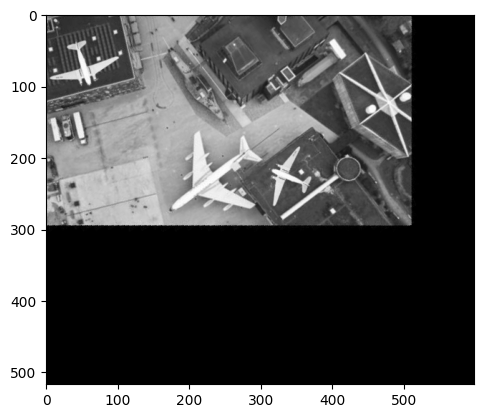

In [10]:
plt.imshow(new_image,'gray')

In [11]:
x1,y1 = img_1.shape

In [12]:
img2_crop = new_image[:x1,:y1]

###### copped image

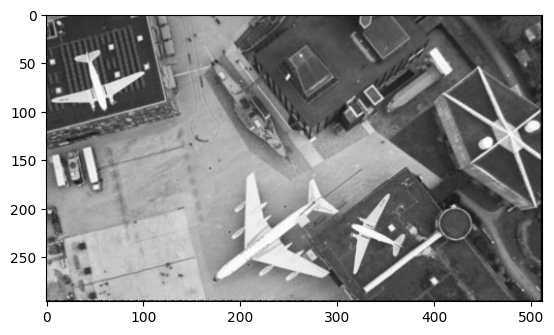

In [13]:
plt.imshow(img2_crop,'gray')

##### subtracted image and applying threshold

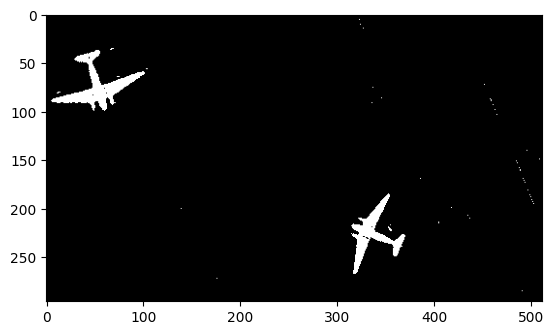

In [15]:
plt.imshow((img2_crop - img_1)>70 , cmap ='gray')

##### final plot

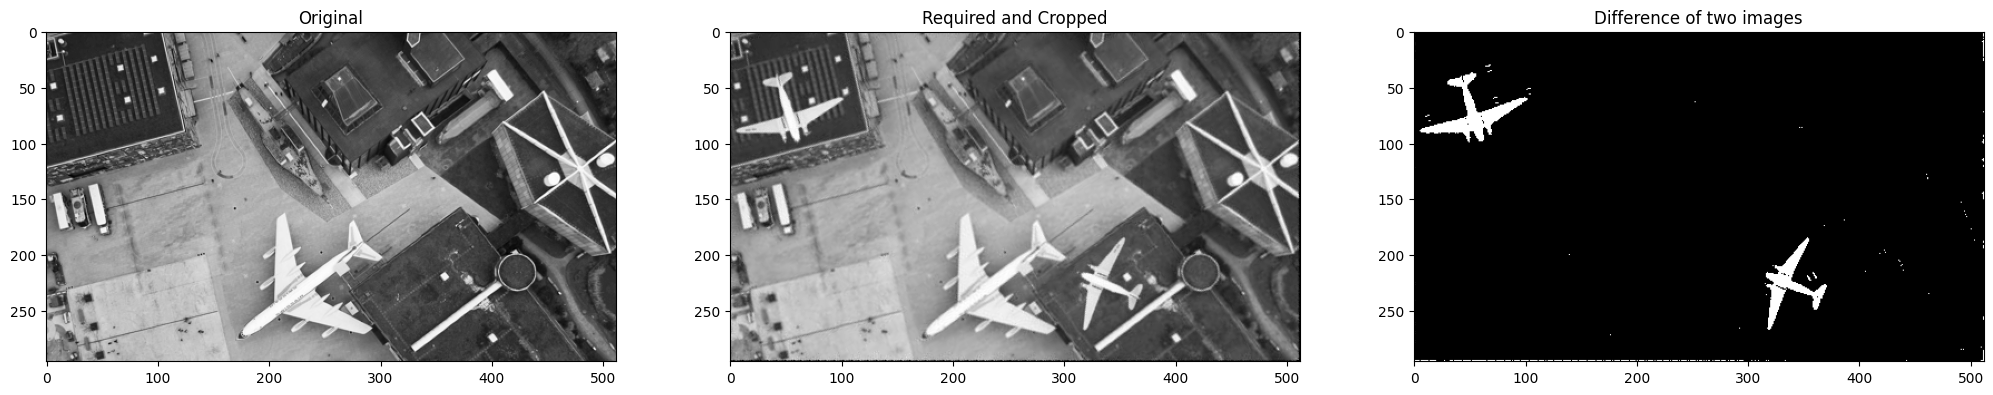

In [16]:
plt.figure(figsize=(25,18))
plt.subplot(1,3,1)
plt.imshow(img_1,cmap ='gray')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(img2_crop,cmap ='gray')
plt.title('Required and Cropped')
plt.subplot(1,3,3)
plt.imshow(abs(img2_crop - img_1)>80 , cmap ='gray')
plt.title('Difference of two images')
plt.show()

##### Learnings
* points 1 to points 2 if we do the homography , image moves out and not aligned to old one , so it must 2 to 1 always 
* proper alignment of image points are needed , else it will result in different image and we cannot detect the difference 
* can be called as a registration task (we are given the points)
* need to try this on SIFT and SURd to see if its able to given this (if given what is the error)